## Setting up an environment and importing necessary libraries

In [1]:
import keras
import tensorflow as tf

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6201954111298236630
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3178807296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17386385113048088165
physical_device_desc: "device: 0, name: GeForce GTX 965M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, Activation, SpatialDropout1D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Importing data, cleaning and checking decompostition

In [4]:
data = pd.read_csv(".\\fraud_log.csv")

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
print("Operation type:\n", data.type.value_counts())

Operation type:
 CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


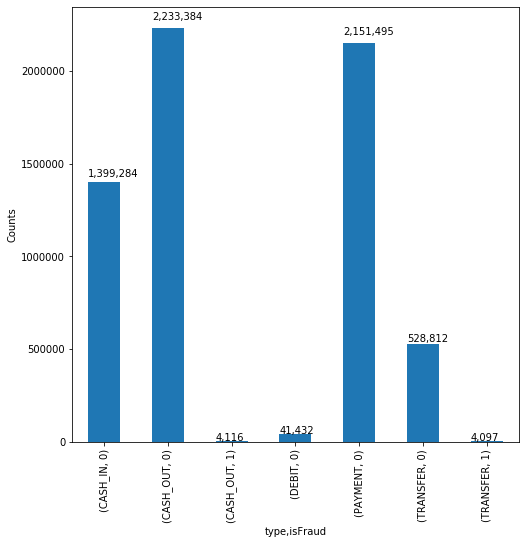

In [10]:
ax = data.groupby(['type', 'isFraud']).size().plot(kind='bar',figsize=(8,8))
plt.ylabel('Counts')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.02))

In [11]:
print("Is fraud: \n", data.isFraud.value_counts())

Is fraud: 
 0    6354407
1       8213
Name: isFraud, dtype: int64


In [12]:
print("Is flagged as fraud:\n", data.isFlaggedFraud.value_counts())

Is flagged as fraud:
 0    6362604
1         16
Name: isFlaggedFraud, dtype: int64


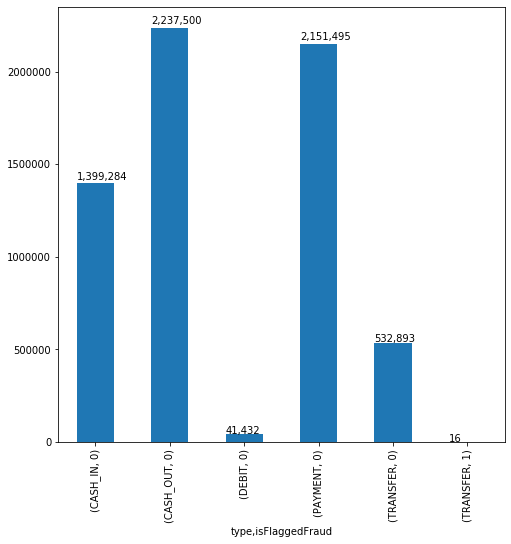

In [13]:
ax = data.groupby(['type','isFlaggedFraud']).size().plot(kind='bar', figsize=(8,8))

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

In [14]:
data2 = data.corr()

In [15]:
import seaborn as sns

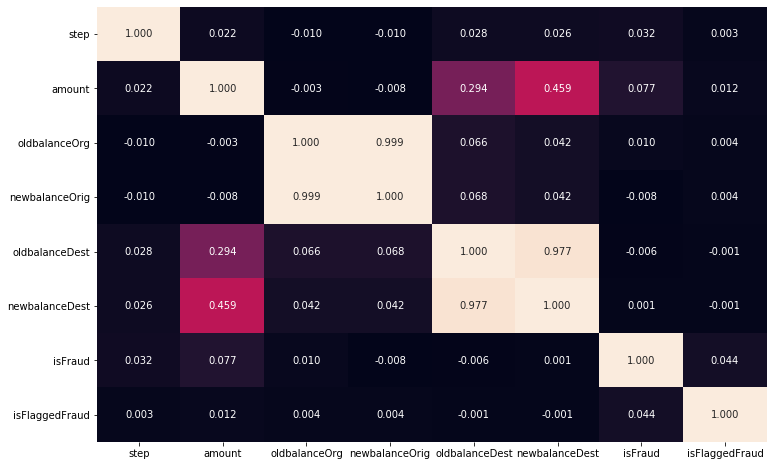

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(data2, annot=True, fmt='.3f',cbar=False)

In [17]:
#Dropping most correlated features
data = data.drop(['oldbalanceDest','oldbalanceOrg'],axis = 1)

In [18]:
df = pd.get_dummies(data.type,drop_first=True)

In [19]:
data = pd.concat([data,df],axis=1)

In [20]:
data.head()

,step,type,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,160296.36,M1979787155,0.0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,19384.72,M2044282225,0.0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,0.00,C553264065,0.0,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,0.00,C38997010,0.0,1,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,29885.86,M1230701703,0.0,0,0,0,0,1,0


In [21]:
data.drop(['type','nameOrig','nameDest'],axis=1,inplace=True)

## Building Sequential Neural Network

In [22]:
data.columns

Index(['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
      dtype='object')

In [23]:
data = data[['step', 'amount', 'newbalanceOrig', 'newbalanceDest',  'isFlaggedFraud', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'isFraud']]

In [24]:
dataset = data.values

In [25]:
X = dataset[:,:10]
y = dataset[:,-1]

In [26]:
X_scale = MinMaxScaler(X)

In [27]:
X_train, X_valtes, y_train, y_valtes = train_test_split(X, y, test_size=0.2, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_valtes,y_valtes,test_size=0.5)

In [28]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(5090096, 10) (5090096,) (636262, 10) (636262,) (636262, 10) (636262,)


In [29]:
model = Sequential()
model.add(Dense(units=32,activation='relu',input_dim=10))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

earlyStopping = EarlyStopping(monitor='val_loss', 
                            patience=15, 
                            verbose=0, 
                            mode='min'
                            )
mcp_save = ModelCheckpoint('.mdl_wts1.hdf5', 
                            save_best_only=True,monitor='val_loss',
                            mode='min'
                            )
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', 
                            factor=0.1, 
                            patience=7, 
                            verbose=1,
                            epsilon=1e-4,
                            mode='min'
                            )

hist = model.fit(X_train,
                y_train,
                batch_size=4096,
                epochs=100,
                validation_data=(X_val,y_val),
                callbacks=[earlyStopping,mcp_save,reduce_lr_loss])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 5090096 samples, validate on 636262 samples
Epoch 1/100
5090096/5090096 [==============================] - 10s 2us/step - loss: 341.3716 - accuracy: 0.9795 - val_loss: 31.4251 - val_accuracy: 0.9898
Epoch 2/100
5090096/5090096 [==============================] - 9s 2us/step - loss: 28.4302 - accuracy: 0.9854 - val_loss: 31.9676 - val_accuracy: 0.9948
Epoch 3/100
5090096/5090096 [==============================] - 9s 2us/step - loss: 22.8972 - accuracy: 0.9885 - val_loss: 4.9352 - val_accuracy: 0.9932
Epoch 4/100
5090096/5090096 [==============================] - 9s 2us/step - loss: 22.3485 - accuracy: 0.9887 - val_loss: 18.1316 - val_accuracy: 0.9886
Epoch 5/100
5090096/5090096 [==============================] - 9s 2us/step - loss: 22.6864 - accuracy: 0.9895 - val_loss: 23.0959 - val_accuracy: 0.9946
Epoch 6/100
5090096/5090096 [==============================] - 9s 2us/step - loss: 14.

In [30]:
accuracy = model.evaluate(X_test,y_test)[1]

636262/636262 [==============================] - 34s 53us/step


In [31]:
print("Accuracy:", round(accuracy,4))

Accuracy: 0.9993


In [32]:
pred = model.predict(X_test)
pred = [1 if y>=.5 else 0 for y in pred]
print("Accuracy score\n", round(accuracy_score(y_test,pred),4))
print("\nClassification report\n",classification_report(y_test,pred))
ax = sns.heatmap(confusion_matrix(y_test,pred),annot=True,fmt='.0f', cbar=False,xticklabels=classes,yticklabels=classes)

Accuracy score
 0.9993

Classification report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    635421
         1.0       1.00      0.51      0.67       841

    accuracy                           1.00    636262
   macro avg       1.00      0.75      0.84    636262
weighted avg       1.00      1.00      1.00    636262



NameError: name 'classes' is not defined

Despite of high model accuracy, we can see that model is classifying all cases as Not fraud. It cannot learn, beacues we have highly unbalanced dataset, 6,354,407 cases are marked as not fraud and only 8,213 are frauds. So this approach gives any added value.

For comparison we will perform on this dataset Decision Tree Classifier.

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
decTreClas = DecisionTreeClassifier()
decTreClas.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy score
 1.0

Classification report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    635421
         1.0       1.00      1.00      1.00       841

    accuracy                           1.00    636262
   macro avg       1.00      1.00      1.00    636262
weighted avg       1.00      1.00      1.00    636262



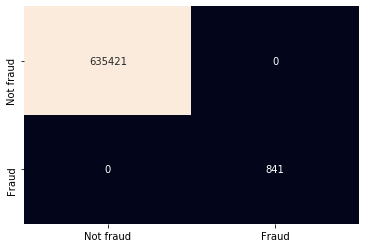

In [35]:
pred1 = decTreClas.predict(X_test)
classes = ['Not fraud', 'Fraud']
print("Accuracy score\n", round(accuracy_score(y_test,pred1),4))
print("\nClassification report\n",classification_report(y_test,pred1))
ax = sns.heatmap(confusion_matrix(y_test,pred1),annot=True,fmt='.0f',
cbar=False,xticklabels=classes,yticklabels=classes)

Accuracy score
 1.0

Classification report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    635476
         1.0       1.00      1.00      1.00       786

    accuracy                           1.00    636262
   macro avg       1.00      1.00      1.00    636262
weighted avg       1.00      1.00      1.00    636262



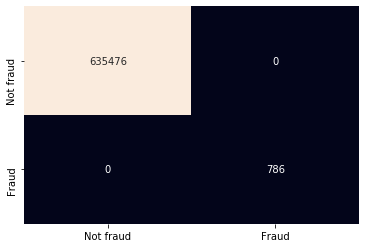

In [36]:
pred2 = decTreClas.predict(X_val)
classes = ['Not fraud', 'Fraud']
print("Accuracy score\n", round(accuracy_score(y_val,pred2),4))
print("\nClassification report\n",classification_report(y_val,pred2))
ax = sns.heatmap(confusion_matrix(y_val,pred2),annot=True,fmt='.0f',
cbar=False,xticklabels=classes,yticklabels=classes)

As we can see from above Decision Tree Classifier is out performing baisic Sequentail Neuron Network, so this solution is capable of predicting is given operation can be potentially classified as fraud or not.

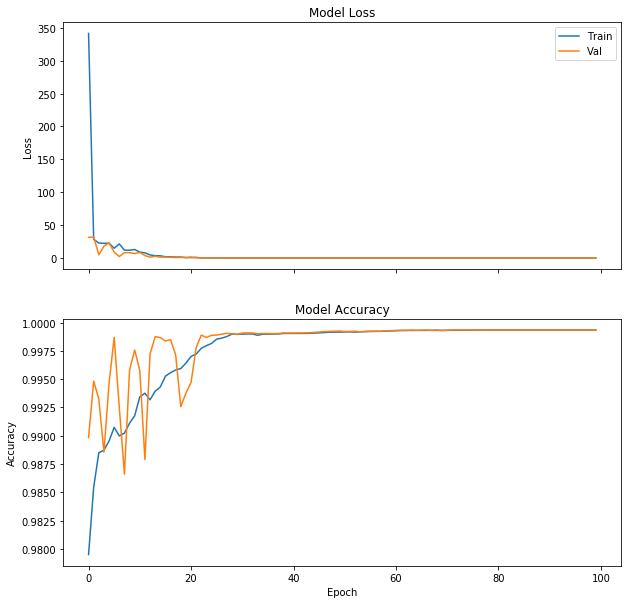

In [37]:
#ploting to see how NN is learning

fig, axs = plt.subplots(2,sharex=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(hist.history['accuracy'])
axs[1].plot(hist.history['val_accuracy'])
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')

for ax in axs.flat:
    ax.label_outer()

To give chance to NN, I will prepare more balanced dataset.

## Preparring data

In [38]:
datafraud = data[data.isFraud == 1]

In [39]:
datanotF = data[data.isFraud == 0]

In [40]:
dataNF = datanotF.sample(n = 10000)

In [41]:
datanew = pd.concat([datafraud,dataNF])

In [42]:
datanew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18213 entries, 2 to 4363546
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            18213 non-null  int64  
 1   amount          18213 non-null  float64
 2   newbalanceOrig  18213 non-null  float64
 3   newbalanceDest  18213 non-null  float64
 4   isFlaggedFraud  18213 non-null  int64  
 5   CASH_OUT        18213 non-null  uint8  
 6   DEBIT           18213 non-null  uint8  
 7   PAYMENT         18213 non-null  uint8  
 8   TRANSFER        18213 non-null  uint8  
 9   isFraud         18213 non-null  int64  
dtypes: float64(3), int64(3), uint8(4)
memory usage: 1.0 MB


In [43]:
datanew.reset_index(inplace=True)

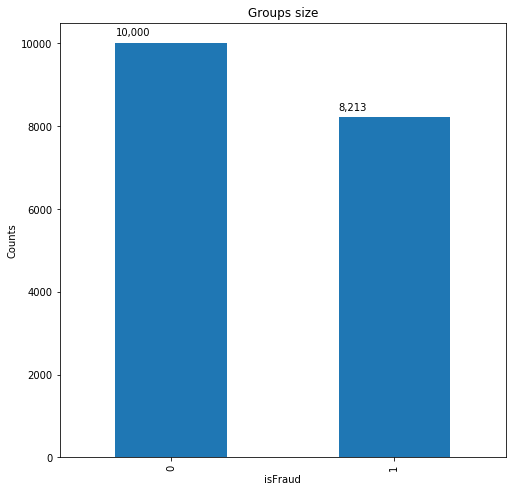

In [44]:
ax = datanew.groupby('isFraud').size().plot(kind='bar',figsize=(8,8))
plt.ylabel('Counts')
plt.title('Groups size')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.02))

In [45]:
datanew2 = datanew.values

In [46]:
Xn = datanew2[:,:10]
yn = datanew2[:,-1]

In [47]:
X_train, X_valtes, y_train, y_valtes = train_test_split(Xn, yn, test_size=0.2, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_valtes,y_valtes,test_size=0.5)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(14570, 10) (14570,) (1821, 10) (1821,) (1822, 10) (1822,)


In [48]:
model2 = Sequential()
model2.add(Dense(units=32,activation='relu',input_dim=10))
model2.add(Dense(units=32,activation='relu'))
model2.add(Dense(units=32,activation='relu'))
model2.add(Dense(units=32,activation='relu'))
model2.add(Dense(units=1,activation='sigmoid'))

model2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

mcp_save = ModelCheckpoint('.mdl_wts2.hdf5', 
                            save_best_only=True,monitor='val_loss',
                            mode='min'
                            )

hist2 = model2.fit(X_train,
                y_train,
                batch_size=4096,
                epochs=100,
                validation_data=(X_val,y_val),
                callbacks=[earlyStopping,mcp_save,reduce_lr_loss])

Train on 14570 samples, validate on 1821 samples
Epoch 1/100
14570/14570 [==============================] - 0s 32us/step - loss: 15804.4778 - accuracy: 0.5226 - val_loss: 9625.2500 - val_accuracy: 0.5612
Epoch 2/100
14570/14570 [==============================] - 0s 2us/step - loss: 6571.6766 - accuracy: 0.5915 - val_loss: 4478.3501 - val_accuracy: 0.5431
Epoch 3/100
14570/14570 [==============================] - 0s 3us/step - loss: 3385.9409 - accuracy: 0.6089 - val_loss: 3077.4006 - val_accuracy: 0.6991
Epoch 4/100
14570/14570 [==============================] - 0s 2us/step - loss: 3045.2581 - accuracy: 0.6444 - val_loss: 2071.1191 - val_accuracy: 0.6019
Epoch 5/100
14570/14570 [==============================] - 0s 3us/step - loss: 2410.5111 - accuracy: 0.7040 - val_loss: 1800.5962 - val_accuracy: 0.7518
Epoch 6/100
14570/14570 [==============================] - 0s 3us/step - loss: 1872.4562 - accuracy: 0.6658 - val_loss: 1033.1667 - val_accuracy: 0.7276
Epoch 7/100
14570/14570 [======

In [49]:
model3 = Sequential()
model3.add(Dense(units=32,activation='relu',input_dim=10))
model3.add(Dense(units=32,activation='relu'))
model3.add(Dense(units=32,activation='relu'))
model3.add(Dense(units=32,activation='relu'))
model3.add(Dense(units=32,activation='relu'))
model3.add(Dense(units=1,activation='sigmoid'))

model3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
                )
mcp_save = ModelCheckpoint('.mdl_wts3.hdf5', 
                            save_best_only=True,monitor='val_loss',
                            mode='min'
                            )

hist3 = model3.fit(X_train,
                y_train,
                batch_size=4096,
                epochs=100,
                validation_data=(X_val,y_val),
                callbacks=[earlyStopping,mcp_save,reduce_lr_loss]
                )

Train on 14570 samples, validate on 1821 samples
Epoch 1/100
14570/14570 [==============================] - 0s 26us/step - loss: 84219.5000 - accuracy: 0.4507 - val_loss: 29063.8359 - val_accuracy: 0.6024
Epoch 2/100
14570/14570 [==============================] - 0s 3us/step - loss: 23115.3281 - accuracy: 0.6106 - val_loss: 17684.5312 - val_accuracy: 0.6315
Epoch 3/100
14570/14570 [==============================] - 0s 3us/step - loss: 15619.8341 - accuracy: 0.6499 - val_loss: 10792.3398 - val_accuracy: 0.6711
Epoch 4/100
14570/14570 [==============================] - 0s 2us/step - loss: 7096.5231 - accuracy: 0.6967 - val_loss: 5216.3467 - val_accuracy: 0.5925
Epoch 5/100
14570/14570 [==============================] - 0s 3us/step - loss: 6376.1137 - accuracy: 0.5687 - val_loss: 5563.8813 - val_accuracy: 0.5783
Epoch 6/100
14570/14570 [==============================] - 0s 3us/step - loss: 4177.9367 - accuracy: 0.6132 - val_loss: 3213.4141 - val_accuracy: 0.7079
Epoch 7/100
14570/14570 [=

Text(0.5, 0, 'Epoch')

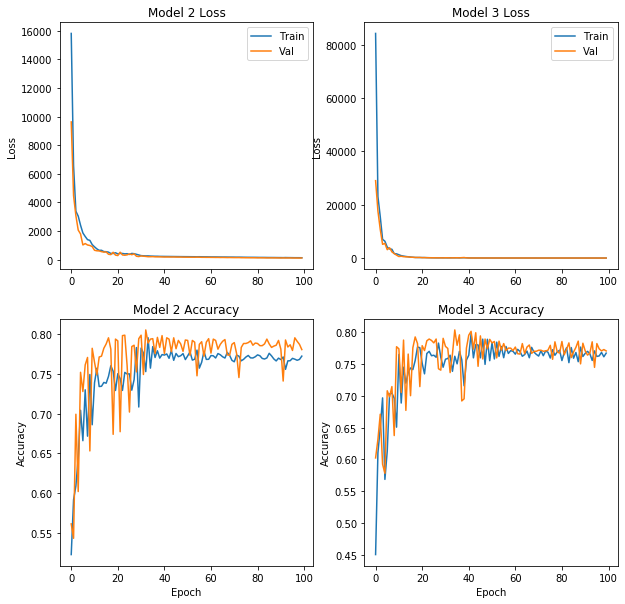

In [50]:
#ploting to see how NN is learning

fig, axs = plt.subplots(2,2, sharex=False)
fig.set_figheight(10)
fig.set_figwidth(10)

axs[0,0].plot(hist2.history['loss'])
axs[0,0].plot(hist2.history['val_loss'])
axs[0,0].set_title('Model 2 Loss')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend(['Train','Val'])

axs[1,0].plot(hist2.history['accuracy'])
axs[1,0].plot(hist2.history['val_accuracy'])
axs[1,0].set_title('Model 2 Accuracy')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_xlabel('Epoch')

axs[0,1].plot(hist3.history['loss'])
axs[0,1].plot(hist3.history['val_loss'])
axs[0,1].set_title('Model 3 Loss')
axs[0,1].set_ylabel('Loss')
axs[0,1].legend(['Train','Val'])

axs[1,1].plot(hist3.history['accuracy'])
axs[1,1].plot(hist3.history['val_accuracy'])
axs[1,1].set_title('Model 3 Accuracy')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_xlabel('Epoch')

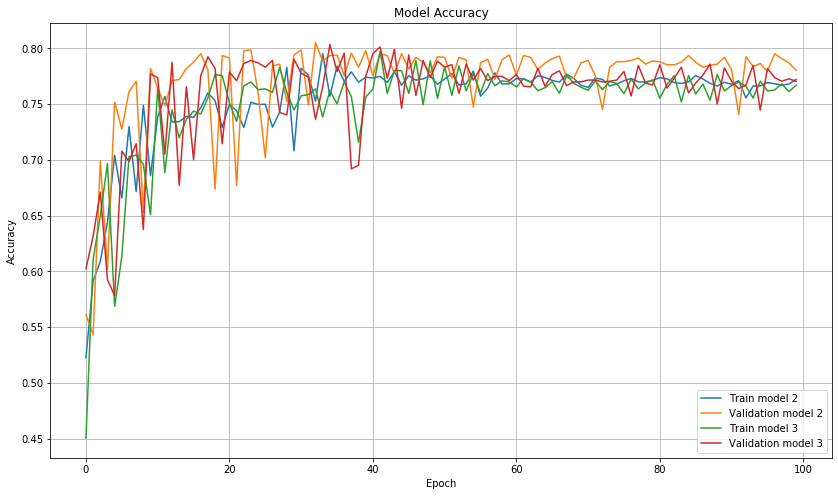

In [51]:
plt.figure(figsize=(14,8))
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train model 2','Validation model 2','Train model 3','Validation model 3'])
plt.grid()

1822/1822 [==============================] - 0s 56us/step
Accuracy score
 0.7602

Classification report
               precision    recall  f1-score   support

         0.0       0.84      0.71      0.77      1024
         1.0       0.69      0.83      0.75       798

    accuracy                           0.76      1822
   macro avg       0.76      0.77      0.76      1822
weighted avg       0.77      0.76      0.76      1822



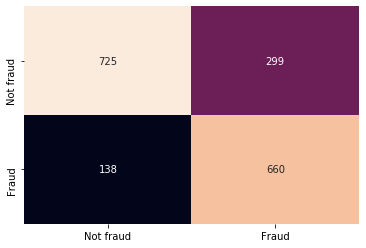

In [52]:
model2.load_weights('.mdl_wts2.hdf5')
model2.evaluate(X_test,y_test)

pred_n2 = model2.predict(X_test)
pred_n2 = [1 if y>=.5 else 0 for y in pred_n2]

print("Accuracy score\n", round(accuracy_score(y_test,pred_n2),4))
print("\nClassification report\n",classification_report(y_test,pred_n2))
ax = sns.heatmap(confusion_matrix(y_test,pred_n2),annot=True,fmt='.0f',
cbar=False,xticklabels=classes,yticklabels=classes)

1822/1822 [==============================] - 0s 62us/step
Accuracy score
 0.7618

Classification report
               precision    recall  f1-score   support

         0.0       0.83      0.73      0.77      1024
         1.0       0.70      0.80      0.75       798

    accuracy                           0.76      1822
   macro avg       0.76      0.77      0.76      1822
weighted avg       0.77      0.76      0.76      1822



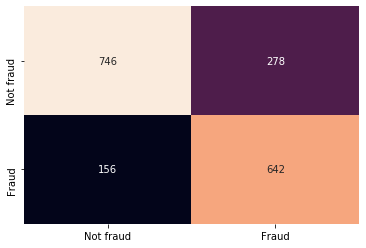

In [53]:
model3.load_weights('.mdl_wts3.hdf5')
model3.evaluate(X_test,y_test)

pred_n3 = model3.predict(X_test)
pred_n3 = [1 if y>=.5 else 0 for y in pred_n3]

print("Accuracy score\n", round(accuracy_score(y_test,pred_n3),4))
print("\nClassification report\n",classification_report(y_test,pred_n3))
ax = sns.heatmap(confusion_matrix(y_test,pred_n3),annot=True,fmt='.0f',
cbar=False,xticklabels=classes,yticklabels=classes)

In [54]:
# Building decision tree calssifier
decTreClas2 = DecisionTreeClassifier()

Accuracy score
 0.9226

Classification report
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1024
         1.0       0.91      0.91      0.91       798

    accuracy                           0.92      1822
   macro avg       0.92      0.92      0.92      1822
weighted avg       0.92      0.92      0.92      1822



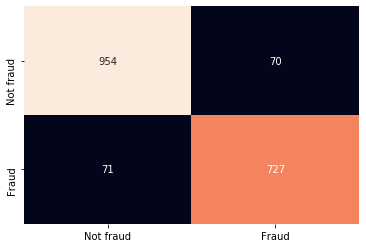

In [55]:
decTreClas2.fit(X_train,y_train)
pred4 = decTreClas2.predict(X_test)
print("Accuracy score\n", round(accuracy_score(y_test,pred4),4))
print("\nClassification report\n",classification_report(y_test,pred4))
ax = sns.heatmap(confusion_matrix(y_test,pred4),annot=True,fmt='.0f',
cbar=False,xticklabels=classes,yticklabels=classes)


Accuracy score
 0.905

Classification report
               precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       971
         1.0       0.90      0.89      0.90       850

    accuracy                           0.90      1821
   macro avg       0.90      0.90      0.90      1821
weighted avg       0.90      0.90      0.90      1821



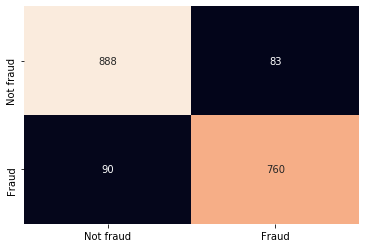

In [56]:
pred5 = decTreClas2.predict(X_val)
print("Accuracy score\n", round(accuracy_score(y_val,pred5),4))
print("\nClassification report\n",classification_report(y_val,pred5))
ax = sns.heatmap(confusion_matrix(y_val,pred5),annot=True,fmt='.0f',
cbar=False,xticklabels=classes,yticklabels=classes)

As we can see even on stripped datasete Decision tree classifier is much better than Sequential Neural Network.